# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [1]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from torch.nn import Softmax
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel, ComplexRNNModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm


In [2]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [3]:
def predict_(model, val_loader, seq_start=None, seq_end=None, step_size=None):

    for i, (x_val, y_val) in enumerate(val_loader):
        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        y_hat = model(x_val)

        if i == 0:
            all_predictions = y_hat
        else:
            all_predictions = torch.cat([all_predictions, y_hat], dim=0)

    return all_predictions


def predict_with_saved_model(model_path, network_dims, test_dataset_path, training_columns, class_columns, 
                             seq_start=None, seq_end=None, step_size=None, scaler_path=None, trials=None, 
                             arch=ComplexRNNModel, multiclass=False, categorical_columns=(), 
                             normalisation_cols=(), device=torch.device("cpu"), return_test_loader=False):
    
    class_columns = list(class_columns)
    training_columns = list(training_columns)

    if scaler_path:
        scaler = joblib.load(scaler_path)
        normalise_data=True
    else:
        scaler = None
        normalise_data=False

    model = arch(*network_dims)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model = model.to(device=device)
    model.eval()

    if trials is None:
        trials = read_dataset(test_dataset_path)

    test_loader, _ = prepare_dataset([trials], class_columns, normalise_data=normalise_data,
                                     scaler=scaler, training_columns=training_columns, multiclass=multiclass,
                                     categorical_columns=categorical_columns, normalisation_cols=normalisation_cols,
                                     device=device)

    return predict_(model, test_loader, seq_start=seq_start, step_size=step_size, seq_end=seq_end)


def get_question_predictions_for_group_of_models(question_type):
    normalise_data = True
    scaler_path = "scalers/passive_dual_scaler.sk"
    network_dims = (len(BASIC_TRAINING_COLS), 25, 3, 0.5)
    dataset_path = "../new_exp_data/exp7_passive.h5"
    class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
    multiclass = True
    seq_end = 2700
    step_size = 3
    
    models = sorted(glob.glob("models/train_25_mb/best_"+question_type+"_model_seed_*.pt"))

    group_predictions = []
    
    for model_path in tqdm(models):
        predicted = predict_with_saved_model(model_path, network_dims, dataset_path, 
                                             training_columns=BASIC_TRAINING_COLS, 
                                             class_columns=class_columns, step_size=step_size, 
                                             seq_end=seq_end, scaler_path=scaler_path,
                                             arch=MultiBranchModel, multiclass=multiclass, trials=None)

        if question_type == "mass":
            predicted = predicted[0]
        else:
            predicted = predicted[1]

        group_predictions.append(predicted.detach())

    return torch.stack(group_predictions)

def get_participant_accuracy(passive_responses, answer_column, question_type_answer):
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    
    return [(df[answer_column] == df[question_type_answer]).sum() / len(df) 
            for _, df in passive_responses.groupby("cond_worldvar")]

# T-test for MASS questions

## Load model's predictions

In [4]:
print("MASS")
question_type = "mass"
group_mass_prediction = get_question_predictions_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_prediction = get_question_predictions_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [00:21<00:00,  1.09it/s]


In [5]:
s = Softmax(dim=2)
group_force_prediction = s(group_force_prediction)
group_mass_prediction = s(group_mass_prediction)

In [6]:
mean_force_prediction = group_force_prediction.mean(dim=0)
mean_mass_prediction = group_mass_prediction.mean(dim=0)

In [7]:
all_predictions = torch.cat((mean_mass_prediction, mean_force_prediction), dim=1).numpy()

In [8]:
model_predictions_df = pd.DataFrame(data=all_predictions, columns=list(MASS_CLASS_COLS) + list(FORCE_CLASS_COLS))

In [9]:
import json

In [10]:
condition_world_variant = []
world_id = []

for condition_id in range(4, 0, -1):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [11]:
model_predictions_df["condition_world_variant"] = condition_world_variant
model_predictions_df["world_id"] = world_id

In [12]:
model_predictions_df.head()

,A,B,same,attract,none,repel,condition_world_variant,world_id
0,0.441233,0.049701,0.509066,0.607577,0.367995,0.024428,4,148
1,0.850630,0.003233,0.146137,0.539758,0.389239,0.071003,4,1282
2,0.067103,0.492469,0.440428,0.870760,0.127154,0.002086,4,1732
3,0.033778,0.542017,0.424205,0.021244,0.372063,0.606694,4,470
4,0.300777,0.175338,0.523885,0.169838,0.776664,0.053498,4,740


## Load human results

In [13]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: In value[[3L]](cond) :
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  "getThreads" not available for .C() for package "RevoUtilsMath"

  warnings.warn(x, RRuntimeWarning)
/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWa

In [14]:
rdata_path = "../new_exp_data/e7_passive.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


# Percentage of participants that chose each answer

In [15]:
passive_responses = []

for name, df in responses.groupby(["cond_worldvar", "world_id", "true_mass", "true_rel"]):
    response = [name[0], name[1], name[2], name[3]]
    
    value_counts = df.resp_rel.value_counts()
    for col in FORCE_CLASS_COLS:
        response.append(value_counts[col])
    
    value_counts = df.resp_mass.value_counts()
    for col in MASS_CLASS_COLS:
        response.append(value_counts[col])
        
    passive_responses.append(response)

In [16]:
passive_responses = pd.DataFrame(data=passive_responses, 
                                 columns=["cond_worldvar", "world_id", 
                                          "true_mass", "true_rel"] + list(FORCE_CLASS_COLS) + list(MASS_CLASS_COLS))

In [17]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,attract,none,repel,A,B,same
0,1,1218,A,repel,4,2,19,13,5,7
1,1,1736,B,none,2,10,13,4,13,8
2,1,1758,B,repel,8,6,11,1,18,6
3,1,1819,B,attract,16,1,8,5,15,5
4,1,438,same,repel,4,7,14,7,9,9


In [18]:
passive_responses["cond_worldvar"] = passive_responses["cond_worldvar"].astype("int64")
passive_responses["world_id"] = passive_responses["world_id"].astype("int64")

In [19]:
passive_responses = passive_responses.merge(model_predictions_df, left_on=["cond_worldvar", "world_id"], 
                                            right_on=["condition_world_variant", "world_id"], 
                                            suffixes=("_human", "_rnn"))

In [20]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,attract_human,none_human,repel_human,A_human,B_human,same_human,A_rnn,B_rnn,same_rnn,attract_rnn,none_rnn,repel_rnn,condition_world_variant
0,1,1218,A,repel,4,2,19,13,5,7,0.833474,0.004516,0.162011,0.055689,0.678818,0.265493,1
1,1,1736,B,none,2,10,13,4,13,8,0.001954,0.974984,0.023061,0.131906,0.632723,0.235371,1
2,1,1758,B,repel,8,6,11,1,18,6,0.014857,0.873476,0.111667,0.025741,0.394418,0.579841,1
3,1,1819,B,attract,16,1,8,5,15,5,0.002911,0.917636,0.079453,0.950938,0.048518,0.000544,1
4,1,438,same,repel,4,7,14,7,9,9,0.098018,0.317427,0.584555,0.040723,0.415041,0.544236,1


In [21]:
passive_responses[['attract_human','none_human', 'repel_human', 'A_human', 'B_human', 'same_human']] /= 25

In [22]:
import matplotlib.pyplot as plt

In [23]:
def plot_correlation(class_columns, true_class):
    
    f, axes = plt.subplots(3, 1, figsize=(10, 30))

    for i, cl in enumerate(class_columns):
        corr_coef = np.corrcoef(passive_responses[cl+"_human"], passive_responses[cl+"_rnn"])[0][1]
        
        is_example_correct = (passive_responses[true_class] == cl)
        passive_responses[is_example_correct].plot(kind="scatter", x=cl+"_rnn", y=cl+"_human", marker="o", ax=axes[i], label="correct", s=50)
        passive_responses[~is_example_correct].plot(kind="scatter", x=cl+"_rnn", y=cl+"_human", c="r", marker="x", ax=axes[i], label="incorrect", s=50)

        axes[i].set_title("Correlation = %.3f" % corr_coef, fontsize=20)
        axes[i].set_xlabel("Average softmax value for the class "+cl, fontsize=20)
        axes[i].set_ylabel("% of participants selecting "+cl, fontsize=20)
        axes[i].legend(fontsize=20)
        axes[i].set_xlim((0, 1))
        axes[i].set_ylim((0, 1))
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        axes[i].grid()

    plt.show()

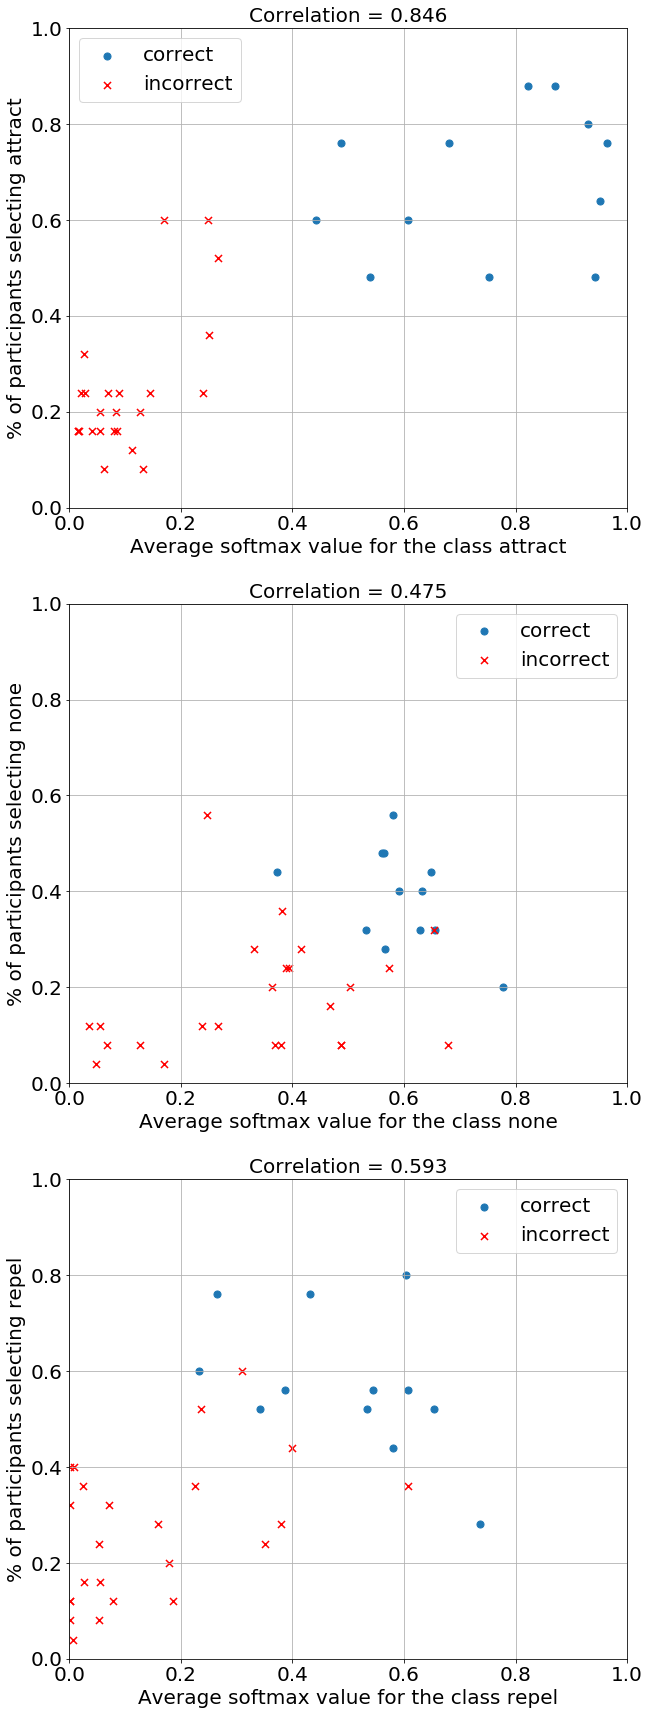

In [24]:
plot_correlation(FORCE_CLASS_COLS, "true_rel")

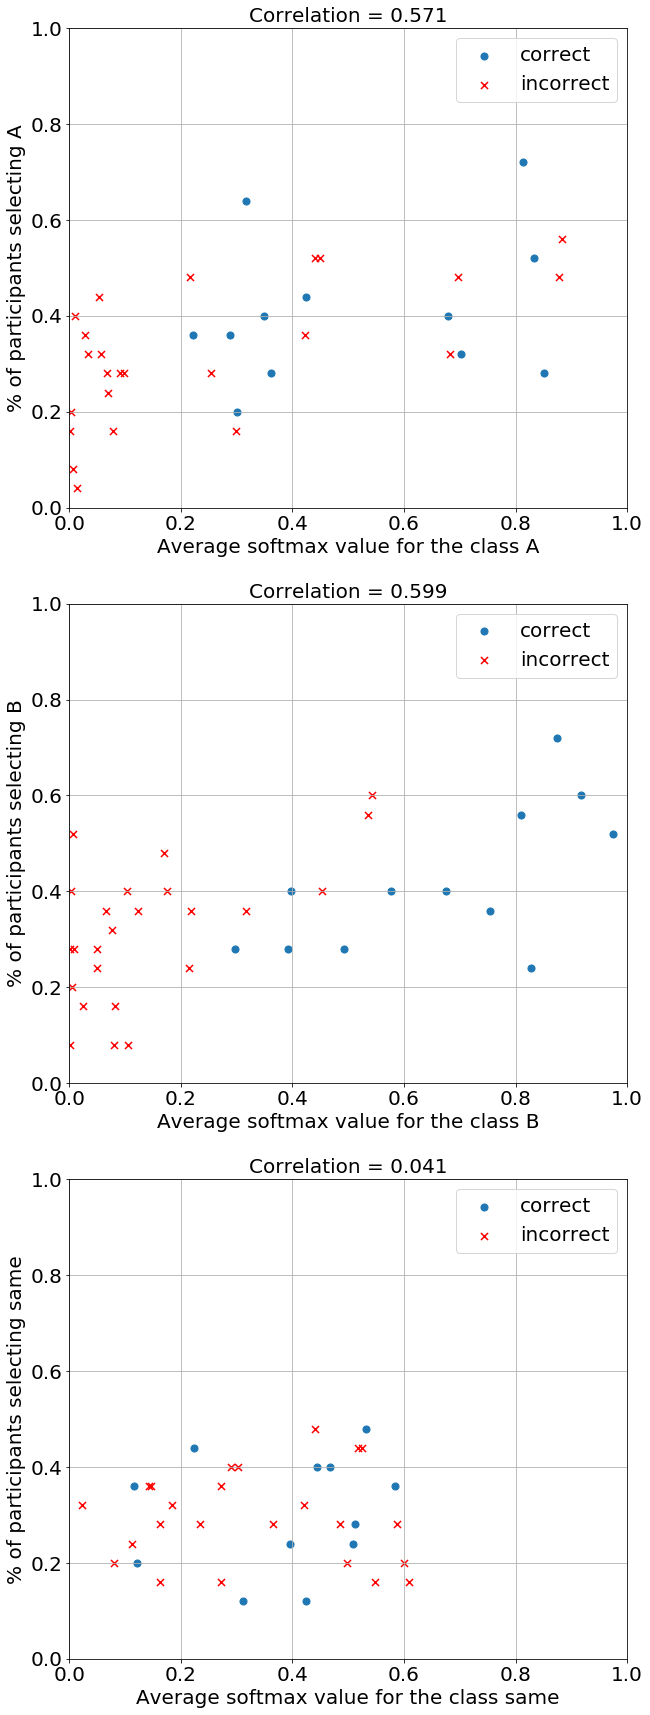

In [25]:
plot_correlation(MASS_CLASS_COLS, "true_mass")

In [26]:
def entropy_response_rnn(responses):
    return -np.sum(responses * np.log2(responses), axis=1)

In [42]:
def get_percentage_of_participants_getting_answer_right(df, question_type):
    
    got_question_right = []
    for _, trial in df.iterrows():
        if question_type == "mass":
            got_question_right.append(trial[trial.true_mass+"_human"])
        elif question_type == "force":
            got_question_right.append(trial[trial.true_rel+"_human"])

    df["got_" + question_type + "_right"] = got_question_right

In [63]:
def get_rnn_answer(df, question_type):
    
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
    
    rnn_answer = []
    rnn_class_probabilities_cols = [cl + "_rnn" for cl in class_columns]

    df["rnn_"+question_type+"_answer"] = [class_columns[x] for x in df[rnn_class_probabilities_cols].values.argmax(axis=1)]

In [64]:
get_percentage_of_participants_getting_answer_right(passive_responses, "mass")
get_percentage_of_participants_getting_answer_right(passive_responses, "force")

In [66]:
get_rnn_answer(passive_responses, "mass")
get_rnn_answer(passive_responses, "force")

In [98]:
def plot_entropy_correlation(question_type, true_class, got_question_right):
        
    if question_type == "mass":
        class_columns = MASS_CLASS_COLS
    elif question_type == "force":
        class_columns = FORCE_CLASS_COLS
    
    is_example_correct = (passive_responses[true_class] == passive_responses["rnn_"+question_type+"_answer"])
    
    rnn_class_columns = [cl + "_rnn" for cl in class_columns]
    passive_responses["answer_entropy"] = entropy_response_rnn(passive_responses[rnn_class_columns])
    
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    passive_responses[is_example_correct].plot(kind="scatter", x="answer_entropy", y=got_question_right, 
                                               marker="o", label="rnn is correct", s=50, ax=ax)
    passive_responses[~is_example_correct].plot(kind="scatter", x="answer_entropy", y=got_question_right, 
                                                c="r", marker="x", label="rnn is wrong", s=50, ax=ax)

    # passive_responses.plot(kind="scatter", x="answer_entropy", y=got_question_right, marker="o", s=50, ax=ax)
    corr_coef = np.corrcoef(passive_responses.answer_entropy, passive_responses[got_question_right])[0][1]
    
    plt.title("Correlation = %.3f" % corr_coef, fontsize=20)
    plt.xlabel(question_type+" RNN entropy ", fontsize=20)
    plt.ylabel("% of participants correct ", fontsize=20)
    plt.legend(fontsize=20)
    # plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()

    plt.show()

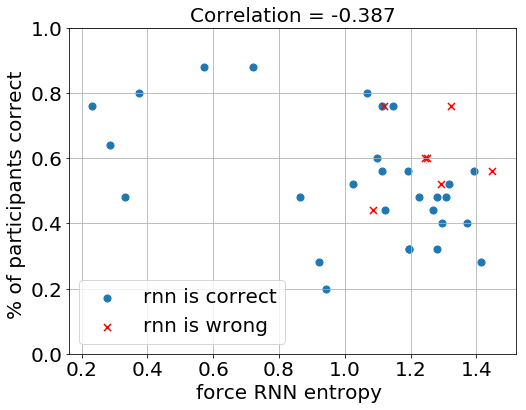

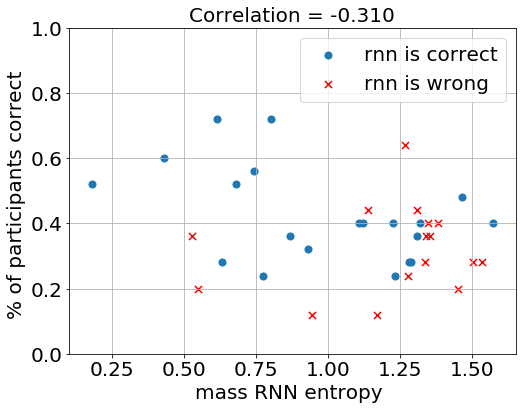

In [99]:
plot_entropy_correlation("force", "true_rel", "got_force_right")
plot_entropy_correlation("mass", "true_mass", "got_mass_right")